# Visualize data

In order to start making interpretations we will generate two visualizations of our data

1. We will verify that the simulated dataset is a good representation of our original input dataset by visually comparing the structures in the two datasets projected onto UMAP space.

2. We will plot the PCA projected data after adding experiments to examine how the technical variation shifted the data.

3. We plot the PCA projected data after correcting for the technical variation introduced by the experiments and examine the effectiveness of the correction method by comparing the data before and after the correction.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import ast
import pandas as pd
import numpy as np
import random
import glob
from plotnine import (ggplot, 
                      geom_point,
                      labs,
                      aes, 
                      facet_wrap, 
                      scale_colour_manual,
                      guides, 
                      guide_legend, 
                      theme_bw, 
                      theme,  
                      element_text,
                      element_rect,
                      element_line,
                      element_blank,
                      ggsave)

from sklearn.decomposition import PCA
from keras.models import load_model
import umap

import warnings
warnings.filterwarnings(action='ignore')

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# User parameters
NN_architecture = 'NN_2500_30'
analysis_name = 'analysis_0'
num_simulated_samples = 6000
lst_num_experiments = [1,2,5,10,20,50,100,500,1000,2000,3000,6000]

In [3]:
# Load data
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../.."))    # base dir on repo
local_dir = "/home/alexandra/Documents"                          # base dir on local machine for data storage

NN_dir = base_dir + "/models/" + NN_architecture
latent_dim = NN_architecture.split('_')[-1]

normalized_data_file = os.path.join(
    base_dir,
    "data",
    "input",
    "train_set_normalized.pcl")

model_encoder_file = glob.glob(os.path.join( ## Make more explicit name here
    NN_dir,
    "tybalt_2layer_{}latent_encoder_model.h5".format(latent_dim)))[0]

weights_encoder_file = glob.glob(os.path.join(
    NN_dir,
    "tybalt_2layer_{}latent_encoder_weights.h5".format(latent_dim)))[0]

model_decoder_file = glob.glob(os.path.join(
    NN_dir,
    "tybalt_2layer_{}latent_decoder_model.h5".format(latent_dim)))[0]

weights_decoder_file = glob.glob(os.path.join(
    NN_dir,
    "tybalt_2layer_{}latent_decoder_weights.h5".format(latent_dim)))[0]

experiment_dir = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "experiment_simulated",
    analysis_name)

simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "simulated_data.txt.xz")

permuted_simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "permuted_simulated_data.txt.xz")

In [4]:
# Output files
umap_overlay_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "output",
    "analysis_0_umap_overlay.png")

pca_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "output",
    "analysis_0_pca_variation.png")

pca_blk_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "output",
    "analysis_0_pca_variation_blk.png")

pca_correct_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "output",
    "analysis_0_pca_correction.png")

pca_correct_blk_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "output",
    "analysis_0_pca_correction_blk.png")

## 1. Visualize simulated data in UMAP space

In [5]:
# Load saved models
loaded_model = load_model(model_encoder_file)
loaded_decode_model = load_model(model_decoder_file)

loaded_model.load_weights(weights_encoder_file)
loaded_decode_model.load_weights(weights_decoder_file)

In [6]:
# Read data
normalized_data = pd.read_table(
    normalized_data_file,
    header=0,
    sep='\t',
    index_col=0).T

simulated_data = pd.read_table(
    simulated_data_file,
    header=0,
    sep='\t',
    index_col=0)

print(normalized_data.shape)
print(simulated_data.shape)

(950, 5549)
(6000, 5549)


In [7]:
normalized_data.head(10)

Gene_symbol                       PA0001    PA0002    PA0003    PA0004  \
05_PA14000-4-2_5-10-07_S2.CEL   0.853357  0.725280  0.640617  0.811465   
54375-4-05.CEL                  0.778790  0.767873  0.614859  0.907865   
AKGlu_plus_nt_7-8-09_s1.CEL     0.789155  0.729508  0.725913  0.718989   
anaerobic_NO3_1.CEL             0.716320  0.585079  0.390211  0.193248   
anaerobic_NO3_2.CEL             0.658015  0.592172  0.410331  0.245504   
control1aerobic_Pae_G1a.CEL     0.365512  0.572967  0.417762  0.663096   
control1_anaerobic_Pae_G1a.CEL  0.689254  0.723461  0.510094  0.801569   
control2aerobic_Pae_G1a.CEL     0.353000  0.580626  0.302544  0.639624   
control2_anaerobic_Pae_G1a.CEL  0.674305  0.680740  0.515478  0.747121   
control3aerobic_Pae_G1a.CEL     0.399186  0.653977  0.328755  0.692895   

Gene_symbol                       PA0005    PA0006    PA0007    PA0008  \
05_PA14000-4-2_5-10-07_S2.CEL   0.694460  0.533958  0.158865  0.889579   
54375-4-05.CEL                  0.398800  0.460849  0.113876  0.761351   
AKGlu_plus_nt_7-8-09_s1.CEL     0.530160  0.466327  0.079507  0.731643   
anaerobic_NO3_1.CEL             0.279456  0.301781  0.513547  0.342051   
anaerobic_NO3_2.CEL             0.312028  0.305852  0.513499  0.336723   
control1aerobic_Pae_G1a.CEL     0.424846  0.606590  0.378900  0.224257   
control1_anaerobic_Pae_G1a.CEL  0.619374  0.937262  0.138600  0.298615   
control2aerobic_Pae_G1a.CEL     0.281793  0.687343  0.462645  0.000000   
control2_anaerobic_Pae_G1a.CEL  0.656701  0.910654  0.149744  0.262492   
control3aerobic_Pae_G1a.CEL     0.482482  0.618446  0.308135  0.191401   

Gene_symbol                       PA0009    PA0010    ...       PA5561  \
05_PA14000-4-2_5-10-07_S2.CEL   0.884945  0.176558    ...     0.466871   
54375-4-05.CEL                  0.801740  0.222709    ...     0.352020   
AKGlu_plus_nt_7-8-09_s1.CEL     0.827707  0.241847    ...     0.392405   
anaerobic_NO3_1.CEL             0.415668  0.125914    ...     0.398308   
anaerobic_NO3_2.CEL             0.334226  0.162965    ...     0.407801   
control1aerobic_Pae_G1a.CEL     0.161582  0.074461    ...     0.491161   
control1_anaerobic_Pae_G1a.CEL  0.306533  0.032482    ...     0.754845   
control2aerobic_Pae_G1a.CEL     0.107961  0.093163    ...     0.466139   
control2_anaerobic_Pae_G1a.CEL  0.263528  0.019910    ...     0.775338   
control3aerobic_Pae_G1a.CEL     0.201170  0.020375    ...     0.560889   

Gene_symbol                       PA5562    PA5563    PA5564    PA5565  \
05_PA14000-4-2_5-10-07_S2.CEL   0.702785  0.790965  0.893249  0.789939   
54375-4-05.CEL                  0.694387  0.733186  0.639074  0.681204   
AKGlu_plus_nt_7-8-09_s1.CEL     0.700352  0.773422  0.791118  0.931585   
anaerobic_NO3_1.CEL             0.419574  0.593955  0.527203  0.706524   
anaerobic_NO3_2.CEL             0.478697  0.571460  0.473054  0.669643   
control1aerobic_Pae_G1a.CEL     0.565151  0.595824  0.382989  0.352268   
control1_anaerobic_Pae_G1a.CEL  0.711126  0.589279  0.542699  0.591066   
control2aerobic_Pae_G1a.CEL     0.545104  0.487957  0.330583  0.419139   
control2_anaerobic_Pae_G1a.CEL  0.653142  0.642205  0.550935  0.565532   
control3aerobic_Pae_G1a.CEL     0.654797  0.493961  0.454766  0.464733   

Gene_symbol                       PA5566    PA5567    PA5568    PA5569  \
05_PA14000-4-2_5-10-07_S2.CEL   0.164157  0.970470  0.887472  0.900484   
54375-4-05.CEL                  0.110301  0.619554  0.747656  0.749893   
AKGlu_plus_nt_7-8-09_s1.CEL     0.172570  0.797148  0.753785  0.856253   
anaerobic_NO3_1.CEL             0.205510  0.504767  0.105662  0.363409   
anaerobic_NO3_2.CEL             0.155548  0.562927  0.049738  0.388931   
control1aerobic_Pae_G1a.CEL     0.250905  0.362161  0.487777  0.729434   
control1_anaerobic_Pae_G1a.CEL  0.421389  0.392671  0.686055  0.911163   
control2aerobic_Pae_G1a.CEL     0.328478  0.298493  0.254059  0.588305   
control2_anaerobic_Pae_G1a.CEL  0.458622  0.426767  0.701314  0.886074   


In [8]:
simulated_data.head(10)

0      1      2      3      4      5      6      7      8      9  \
0  0.690  0.643  0.455  0.651  0.375  0.414  0.354  0.567  0.447  0.165   
1  0.691  0.655  0.527  0.681  0.372  0.443  0.374  0.533  0.503  0.166   
2  0.826  0.695  0.510  0.643  0.611  0.518  0.344  0.631  0.663  0.200   
3  0.601  0.565  0.417  0.595  0.383  0.440  0.387  0.466  0.402  0.224   
4  0.622  0.616  0.473  0.600  0.402  0.481  0.364  0.445  0.448  0.216   
5  0.736  0.733  0.546  0.633  0.461  0.437  0.325  0.573  0.682  0.203   
6  0.643  0.648  0.450  0.552  0.408  0.422  0.372  0.552  0.531  0.185   
7  0.517  0.568  0.364  0.484  0.346  0.441  0.442  0.475  0.372  0.156   
8  0.747  0.746  0.622  0.749  0.456  0.500  0.261  0.626  0.641  0.206   
9  0.581  0.586  0.419  0.593  0.368  0.406  0.403  0.446  0.450  0.213   

   ...     5539   5540   5541   5542   5543   5544   5545   5546   5547   5548  
0  ...    0.376  0.600  0.563  0.640  0.662  0.325  0.577  0.567  0.708  0.615  
1  ...    0.291  0.591  0.610  0.585  0.597  0.163  0.460  0.532  0.710  0.699  
2  ...    0.589  0.582  0.596  0.672  0.753  0.161  0.522  0.511  0.748  0.728  
3  ...    0.346  0.548  0.471  0.460  0.565  0.256  0.510  0.348  0.579  0.583  
4  ...    0.451  0.532  0.589  0.547  0.578  0.234  0.425  0.502  0.705  0.717  
5  ...    0.414  0.576  0.693  0.643  0.747  0.215  0.510  0.639  0.775  0.746  
6  ...    0.393  0.504  0.558  0.506  0.600  0.214  0.478  0.443  0.641  0.686  
7  ...    0.368  0.488  0.461  0.446  0.480  0.364  0.478  0.388  0.528  0.492  
8  ...    0.421  0.636  0.681  0.676  0.637  0.241  0.595  0.664  0.725  0.708  
9  ...    0.420  0.535  0.509  0.492  0.525  0.258  0.409  0.430  0.594  0.573  

[10 rows x 5549 columns]

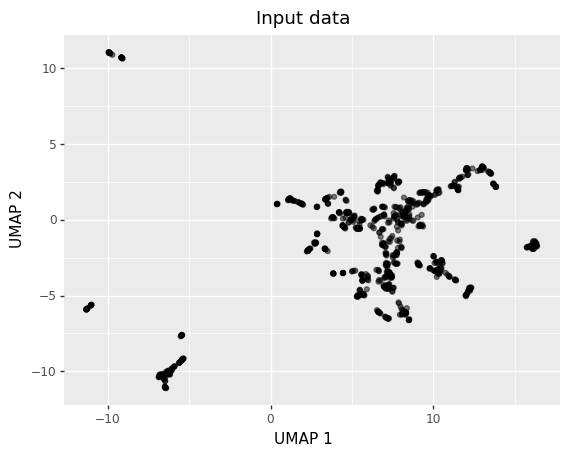

<ggplot: (8754109014157)>


In [9]:
# UMAP embedding of original input data

# Get and save model
model = umap.UMAP(random_state=randomState).fit(normalized_data)

input_data_UMAPencoded = model.transform(normalized_data)
input_data_UMAPencoded_df = pd.DataFrame(data=input_data_UMAPencoded,
                                         index=normalized_data.index,
                                         columns=['1','2'])


g_input = ggplot(input_data_UMAPencoded_df, aes(x='1',y='2')) \
    + geom_point(alpha=0.5) \
    + labs(x = "UMAP 1", y = "UMAP 2", title = "Input data") \

print(g_input)

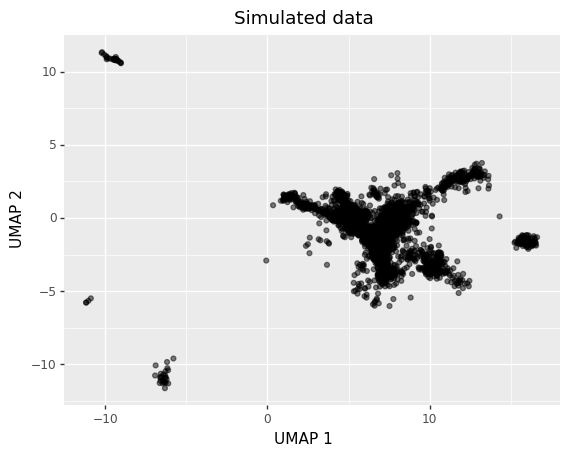

<ggplot: (8754109490973)>


In [10]:
# UMAP embedding of simulated data
simulated_data_UMAPencoded = model.transform(simulated_data)
simulated_data_UMAPencoded_df = pd.DataFrame(data=simulated_data_UMAPencoded,
                                         index=simulated_data.index,
                                         columns=['1','2'])


g_sim = ggplot(simulated_data_UMAPencoded_df, aes(x='1',y='2')) \
    + geom_point(alpha=0.5) \
    + labs(x = "UMAP 1", y = "UMAP 2", title = "Simulated data") \

print(g_sim)

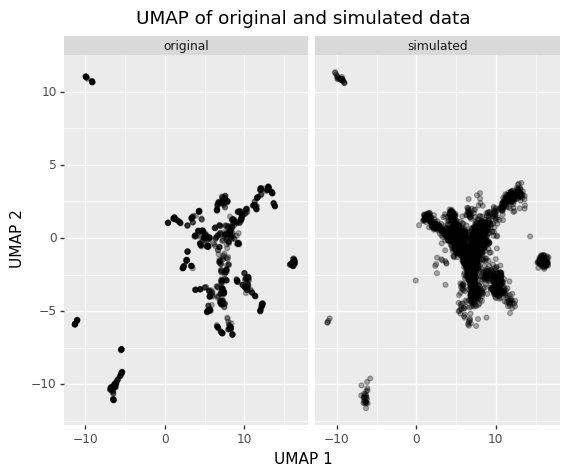

<ggplot: (-9223363282674920581)>

In [11]:
# Side by side original input vs simulated data

# Add label for input or simulated dataset
input_data_UMAPencoded_df['dataset'] = 'original'
simulated_data_UMAPencoded_df['dataset'] = 'simulated'

# Concatenate input and simulated dataframes together
combined_data_df = pd.concat([input_data_UMAPencoded_df, simulated_data_UMAPencoded_df])

# Plot
ggplot(combined_data_df, aes(x='1', y='2')) \
+ geom_point(alpha=0.3) \
+ facet_wrap('~dataset') \
+ labs(x = "UMAP 1", y = "UMAP 2", title = "UMAP of original and simulated data") \

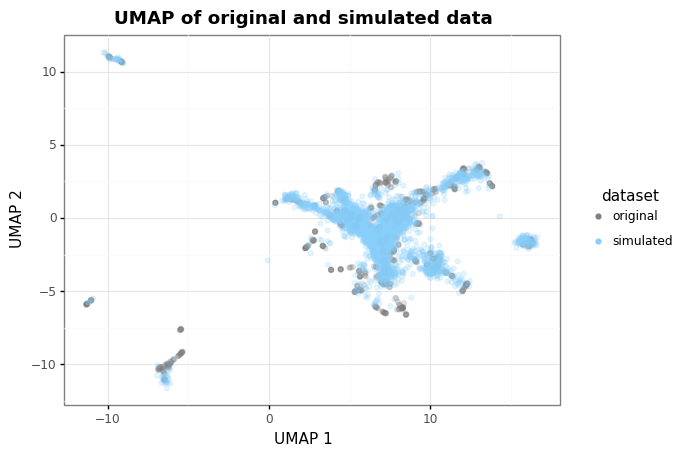

<ggplot: (8754180079203)>


In [12]:
# Overlay original input vs simulated data

# Add label for input or simulated dataset
input_data_UMAPencoded_df['dataset'] = 'original'
simulated_data_UMAPencoded_df['dataset'] = 'simulated'

# Concatenate input and simulated dataframes together
combined_data_df = pd.concat([input_data_UMAPencoded_df, simulated_data_UMAPencoded_df])

# Plot
g_input_sim = ggplot(combined_data_df, aes(x='1', y='2')) \
+ geom_point(aes(color='dataset'), alpha=0.2) \
+ labs(x = "UMAP 1", y = "UMAP 2", title = "UMAP of original and simulated data") \
+ theme_bw() \
+ theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    plot_title=element_text(weight='bold')
) \
+ guides(colour=guide_legend(override_aes={'alpha': 1})) \
+ scale_colour_manual(["grey", '#87CEFA']) 

print(g_input_sim)
ggsave(plot = g_input_sim, filename = umap_overlay_file, dpi=300)

## 2. Visualize effects of multiple experiments in PCA space

Plotting PCA of 1 experiment vs 1 experiments...
[0.24011085 0.16818697]


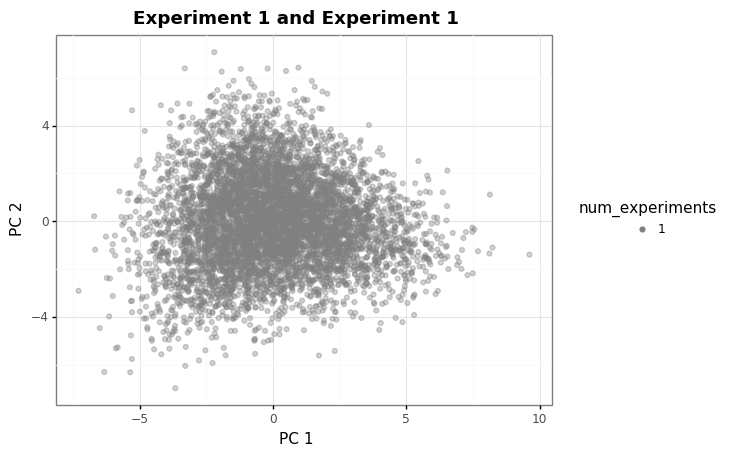

<ggplot: (-9223363282674896019)>
Plotting PCA of 1 experiment vs 2 experiments...
[0.52855779 0.26140588]


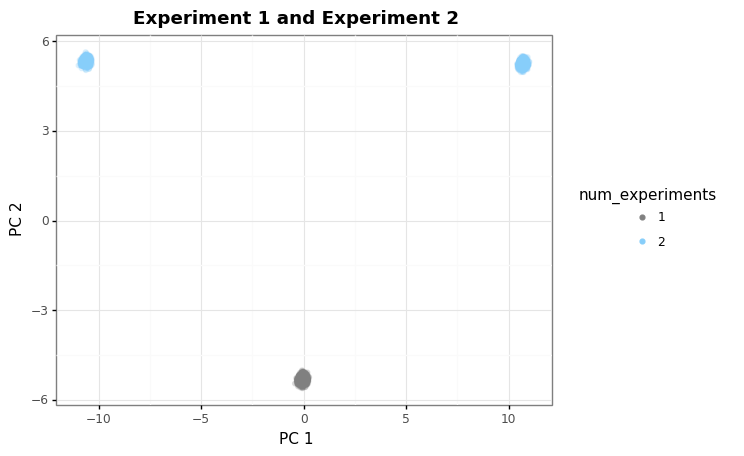

<ggplot: (8754180044948)>
Plotting PCA of 1 experiment vs 5 experiments...
[0.18733086 0.18431429]


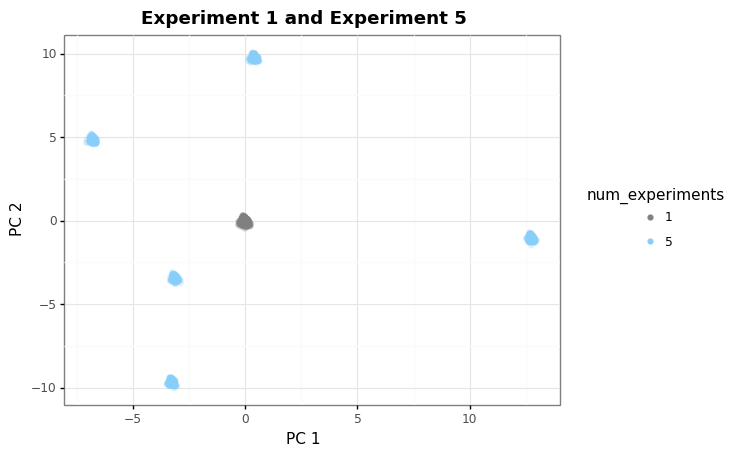

<ggplot: (8754179994958)>
Plotting PCA of 1 experiment vs 10 experiments...
[0.09304023 0.09010752]


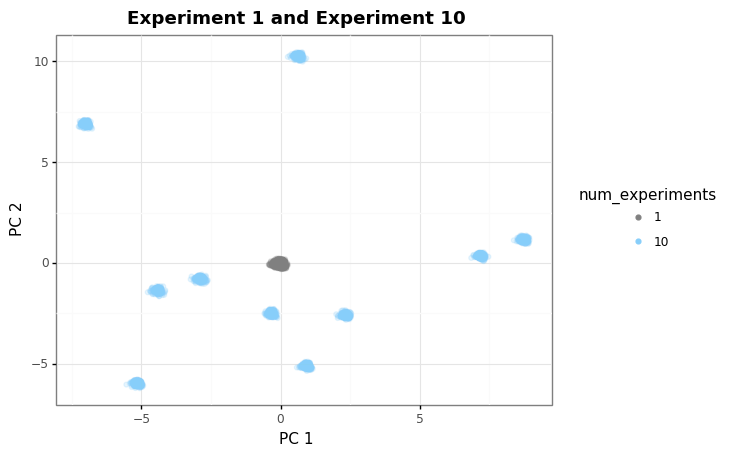

<ggplot: (8754108857762)>
Plotting PCA of 1 experiment vs 20 experiments...
[0.04609459 0.04573577]


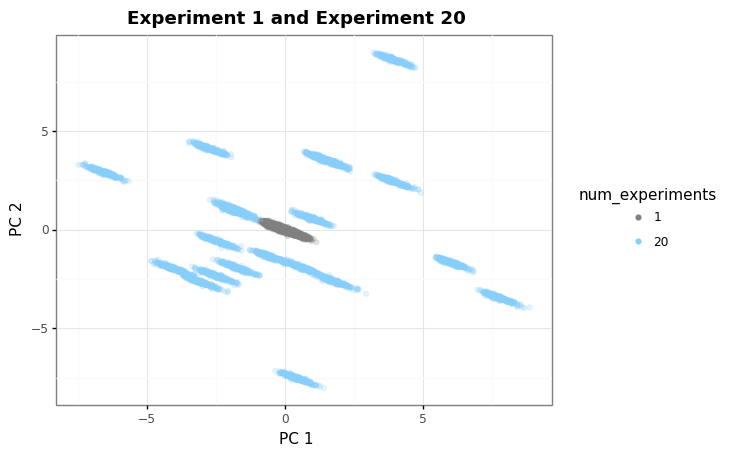

<ggplot: (8754108792552)>
Plotting PCA of 1 experiment vs 50 experiments...
[0.04125434 0.02904663]


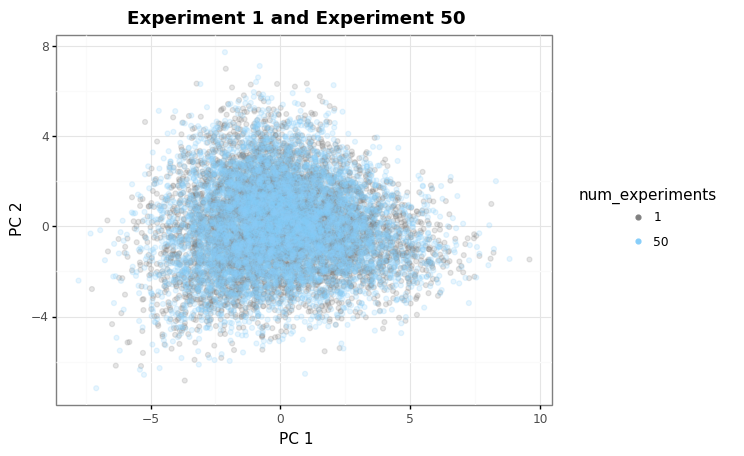

<ggplot: (8754108083625)>
Plotting PCA of 1 experiment vs 100 experiments...
[0.04107571 0.02888625]


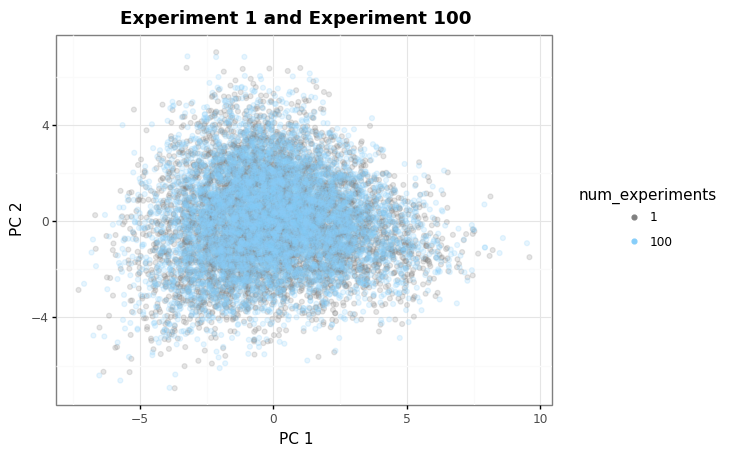

<ggplot: (8753988472822)>
Plotting PCA of 1 experiment vs 500 experiments...
[0.04080679 0.02865807]


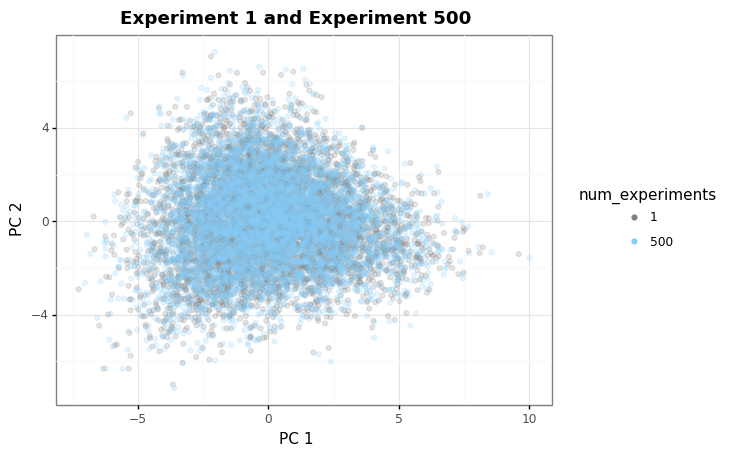

<ggplot: (-9223363282866595363)>
Plotting PCA of 1 experiment vs 1000 experiments...
[0.04080816 0.02869818]


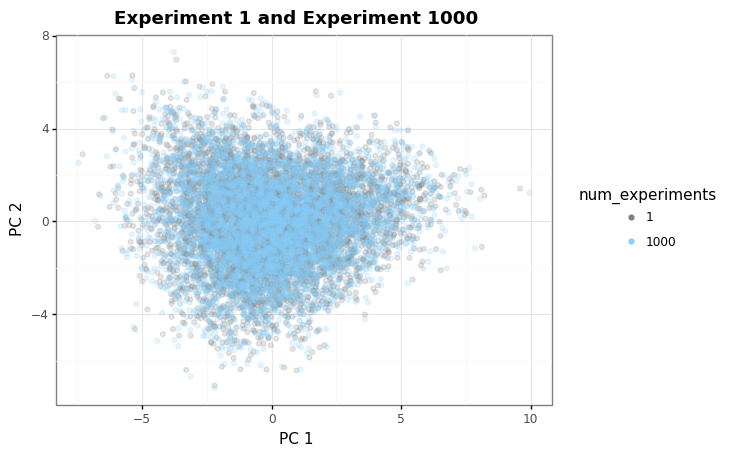

<ggplot: (-9223363282746692124)>
Plotting PCA of 1 experiment vs 2000 experiments...
[0.04086553 0.02875921]


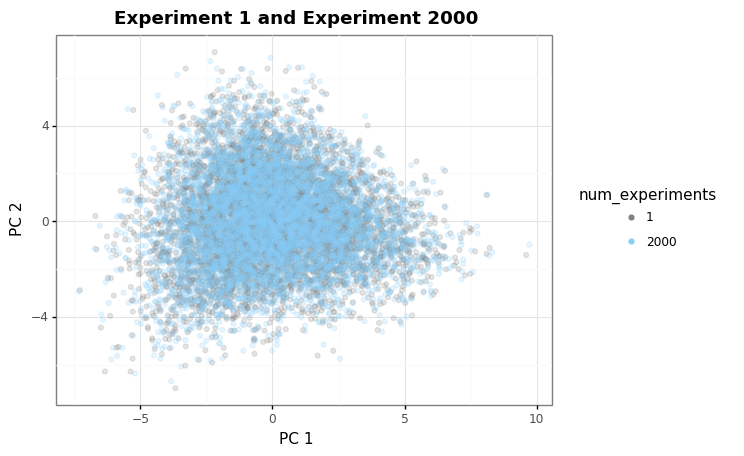

<ggplot: (-9223363282763298921)>
Plotting PCA of 1 experiment vs 3000 experiments...
[0.0407998  0.02868774]


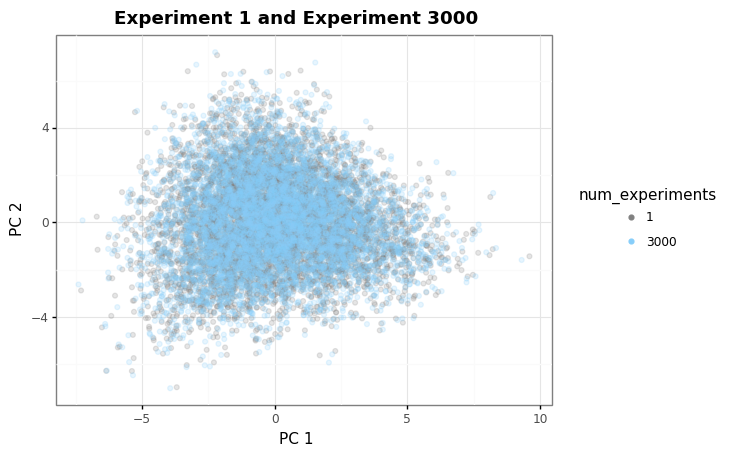

<ggplot: (8754091376872)>
Plotting PCA of 1 experiment vs 6000 experiments...
[0.04070829 0.02867088]


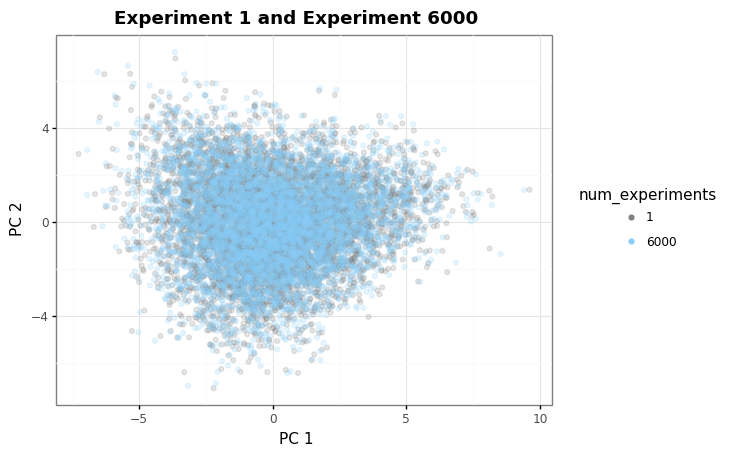

<ggplot: (8753988023146)>
CPU times: user 3min 7s, sys: 54.5 s, total: 4min 2s
Wall time: 2min 29s


In [13]:
%%time

all_data_df = pd.DataFrame()

# Get batch 1 data
experiment_1_file = os.path.join(
    experiment_dir,
    "Experiment_1.txt.xz")

experiment_1 = pd.read_table(
    experiment_1_file,
    header=0,
    index_col=0,
    sep='\t')


for i in lst_num_experiments:
    print('Plotting PCA of 1 experiment vs {} experiments...'.format(i))
    
    # Simulated data with all samples in a single batch
    original_data_df =  experiment_1.copy()
    
    # Add grouping column for plotting
    original_data_df['num_experiments'] = '1'
    
    # Get data with additional batch effects added
    experiment_other_file = os.path.join(
        experiment_dir,
        "Experiment_"+str(i)+".txt.xz")

    experiment_other = pd.read_table(
        experiment_other_file,
        header=0,
        index_col=0,
        sep='\t')
    
    # Simulated data with i batch effects
    experiment_data_df =  experiment_other
    
    # Add grouping column for plotting
    experiment_data_df['num_experiments'] = str(i)
    
    # Concatenate datasets together
    combined_data_df = pd.concat([original_data_df, experiment_data_df])

    # PCA projection
    pca = PCA(n_components=2)

    # Encode expression data into 2D PCA space
    combined_data_numeric_df = combined_data_df.drop(['num_experiments'], axis=1)
    combined_data_PCAencoded = pca.fit_transform(combined_data_numeric_df)


    combined_data_PCAencoded_df = pd.DataFrame(combined_data_PCAencoded,
                                               index=combined_data_df.index,
                                               columns=['PC1', 'PC2']
                                              )
                                              
    # Variance explained
    print(pca.explained_variance_ratio_)  
    
    # Add back in batch labels (i.e. labels = "batch_"<how many batch effects were added>)
    combined_data_PCAencoded_df['num_experiments'] = combined_data_df['num_experiments']
    
    # Add column that designates which batch effect comparision (i.e. comparison of 1 batch vs 5 batches
    # is represented by label = 5)
    combined_data_PCAencoded_df['comparison'] = str(i)
    
    # Concatenate ALL comparisons
    all_data_df = pd.concat([all_data_df, combined_data_PCAencoded_df])
    
    # Plot individual comparisons
    print(ggplot(combined_data_PCAencoded_df, aes(x='PC1', y='PC2')) \
          + geom_point(aes(color='num_experiments'), alpha=0.2) \
          + labs(x = "PC 1", y = "PC 2", title = "Experiment 1 and Experiment {}".format(i))\
          + theme_bw() \
          + theme(
                legend_title_align = "center",
                plot_background=element_rect(fill='white'),
                legend_key=element_rect(fill='white', colour='white'), 
                plot_title=element_text(weight='bold')
            ) \
          + guides(colour=guide_legend(override_aes={'alpha': 1})) \
          + scale_colour_manual(["grey", '#87CEFA'])
         )        

In [14]:
# Convert 'num_experiments' into categories to preserve the ordering
lst_num_experiments_str = [str(i) for i in lst_num_experiments]
num_experiments_cat = pd.Categorical(all_data_df['num_experiments'], categories=lst_num_experiments_str)

# Convert 'comparison' into categories to preserve the ordering
comparison_cat = pd.Categorical(all_data_df['comparison'], categories=lst_num_experiments_str)

# Assign to a new column in the df
all_data_df = all_data_df.assign(num_experiments_cat = num_experiments_cat)
all_data_df = all_data_df.assign(comparison_cat = comparison_cat)

In [15]:
all_data_df.columns = ['PC1', 'PC2', 'num_experiments', 'comparison', 'No. of experiments', 'Comparison']

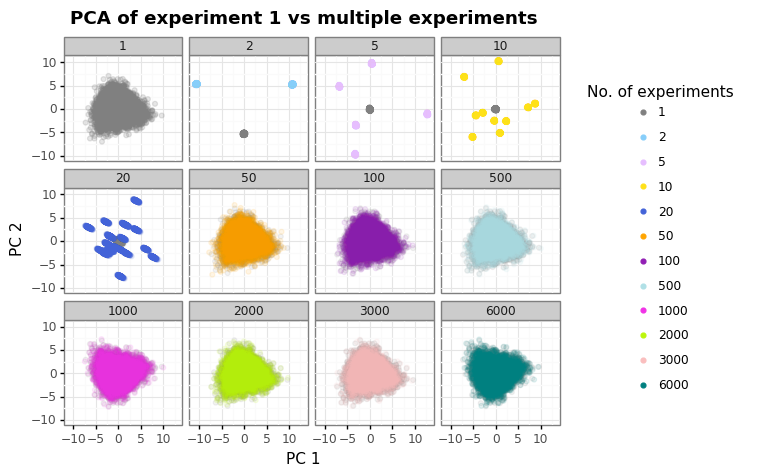

<ggplot: (-9223363282848410515)>


In [16]:
# Plot all comparisons in one figure
g_pca = ggplot(all_data_df, aes(x='PC1', y='PC2')) \
+ geom_point(aes(color='No. of experiments'), alpha=0.1) \
+ facet_wrap('~Comparison') \
+ labs(x = "PC 1", y = "PC 2", title = "PCA of experiment 1 vs multiple experiments") \
+ theme_bw() \
+ theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    plot_title=element_text(weight='bold')
) \
+ guides(colour=guide_legend(override_aes={'alpha': 1})) \
+ scale_colour_manual(["grey", '#87CEFA', '#e6beff', '#ffe119', '#4363d8', '#FFA500', 
                      '#911eb4', '#B0E0E6', '#f032e6', '#bcf60c', '#fabebe', '#008080'])

print(g_pca)
ggsave(plot = g_pca, filename = pca_file, dpi=300)

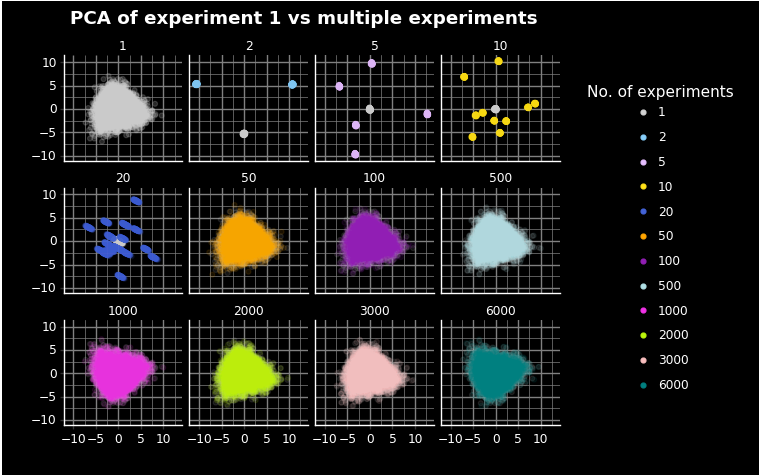

<ggplot: (-9223363282867753072)>


In [17]:
# Plot - black
g_pca = ggplot(all_data_df, aes(x='PC1', y='PC2')) \
+ geom_point(aes(color='No. of experiments'), alpha=0.1) \
+ facet_wrap('~Comparison') \
+ labs(x = "PC 1", y = "PC 2", title = "PCA of experiment 1 vs multiple experiments") \
+ theme(
    plot_background=element_rect(fill='black'),
    legend_title_align = "center",
    legend_background=element_rect(fill='black', colour='black'),
    legend_key=element_rect(fill='black', colour='black'), 
    legend_title=element_text(colour="white"),
    legend_text=element_text(colour="white"),
    plot_title=element_text(weight='bold', colour="white"),
    panel_background=element_rect(fill="black"),
    axis_line=element_line(color="white"),
    axis_text=element_text(color="white"),
    panel_grid=element_line(colour="gray"),
    strip_text=element_text(colour="white"),
    strip_background=element_blank()
    
) \
+ guides(colour=guide_legend(override_aes={'alpha': 1})) \
+ scale_colour_manual(["lightgrey", '#87CEFA', '#e6beff', '#ffe119', '#4363d8', '#FFA500', 
                      '#911eb4', '#B0E0E6', '#f032e6', '#bcf60c', '#fabebe', '#008080'])

print(g_pca)
ggsave(plot = g_pca, filename = pca_blk_file, dpi=300)

## Visualize multiple experiments in UMAP space

Plotting UMAP of 10-PCA of 1 experiment vs 1 experiments...
[0.24011085 0.16818697 0.05297358 0.04230007 0.03976244 0.03451469
 0.03076189 0.0248556  0.02209624 0.02145449]


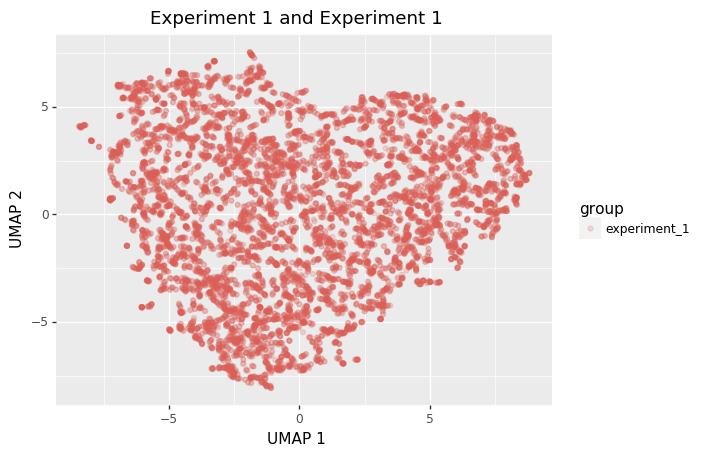

<ggplot: (8753984680754)>
Plotting UMAP of 10-PCA of 1 experiment vs 2 experiments...
[0.52855779 0.26140588 0.050414   0.0353203  0.0111315  0.00888739
 0.00835142 0.00725244 0.00645587 0.00522324]


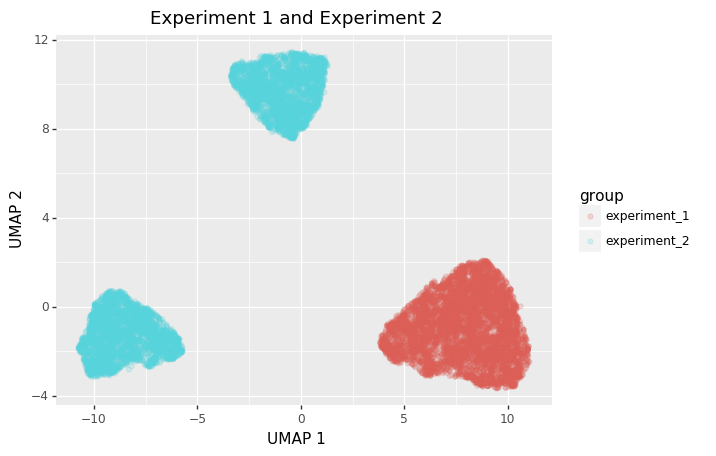

<ggplot: (8754179974990)>
Plotting UMAP of 10-PCA of 1 experiment vs 5 experiments...
[0.18733086 0.18431429 0.18032517 0.17494851 0.08901233 0.04411385
 0.0309889  0.00974581 0.00779331 0.00731893]


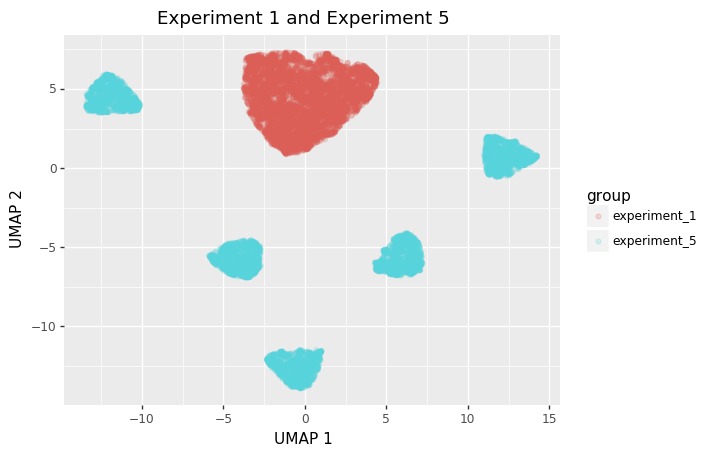

<ggplot: (-9223363282848755824)>
Plotting UMAP of 10-PCA of 1 experiment vs 10 experiments...
[0.09304023 0.09010752 0.08961008 0.08780248 0.08674315 0.08482642
 0.08454559 0.0829289  0.08154191 0.04319194]


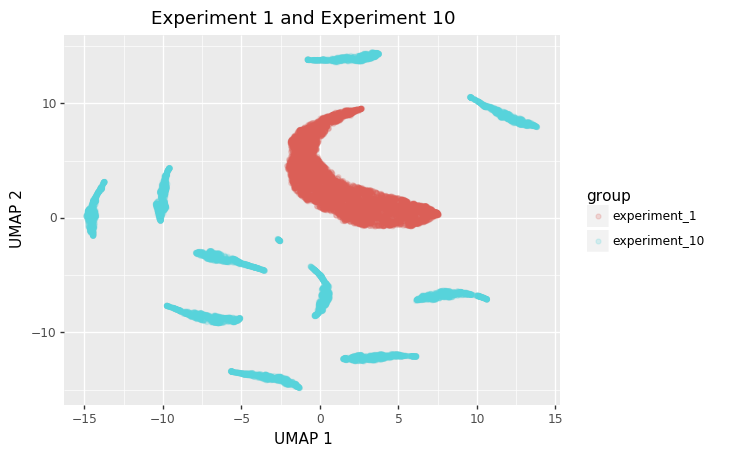

<ggplot: (8754005990243)>
Plotting UMAP of 10-PCA of 1 experiment vs 20 experiments...
[0.04683551 0.04630909 0.04583517 0.04495811 0.04477134 0.04416005
 0.04394881 0.04309372 0.04302845 0.04243369]


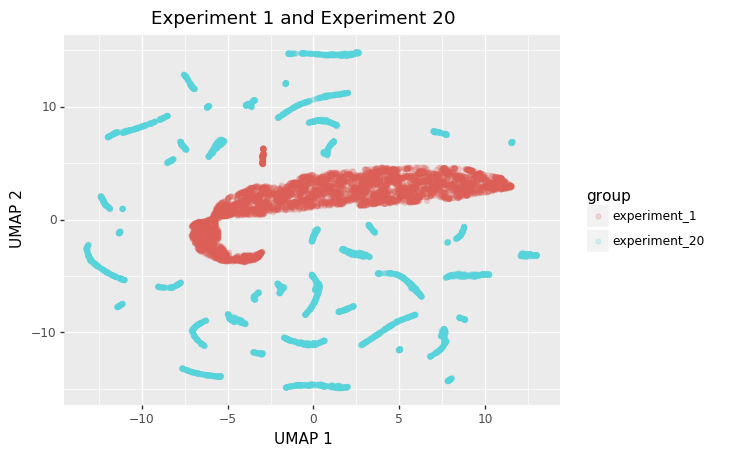

<ggplot: (8754109371235)>
Plotting UMAP of 10-PCA of 1 experiment vs 50 experiments...
[0.04125472 0.02906365 0.01969112 0.01942935 0.01908951 0.01880815
 0.01849078 0.0183644  0.01799206 0.01783613]


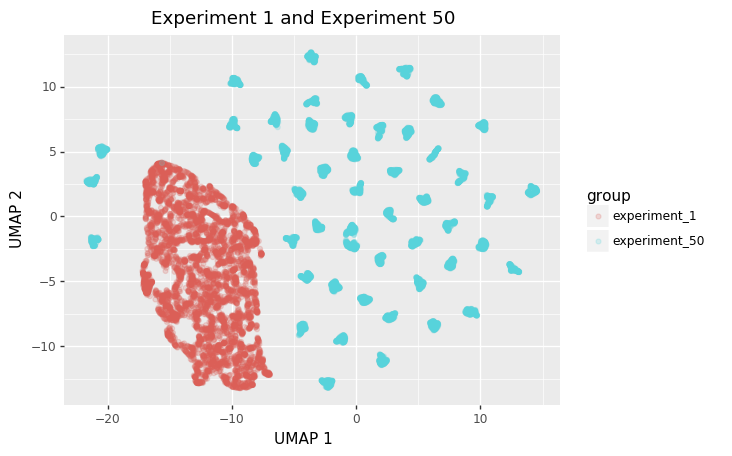

<ggplot: (-9223363282745561621)>
Plotting UMAP of 10-PCA of 1 experiment vs 100 experiments...
[0.04107571 0.02888626 0.01065766 0.01054127 0.01047784 0.01029803
 0.01016259 0.00995082 0.00987099 0.00973602]


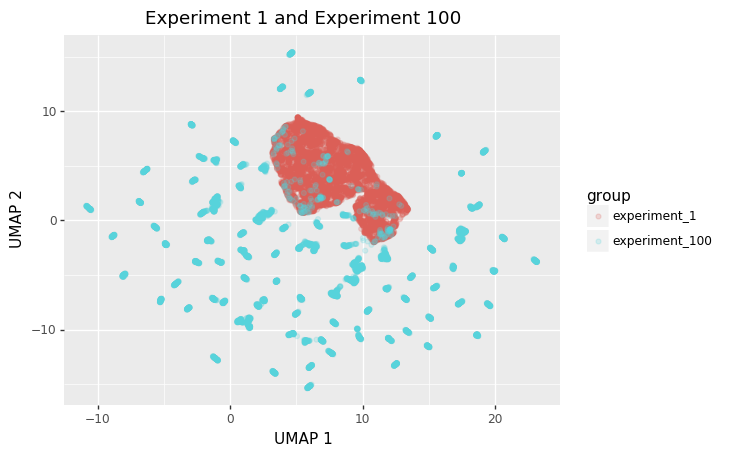

<ggplot: (-9223363282737835369)>
Plotting UMAP of 10-PCA of 1 experiment vs 500 experiments...
[0.04080679 0.02865807 0.00916738 0.00745483 0.00700602 0.00619837
 0.00549768 0.00452592 0.00408502 0.0039887 ]


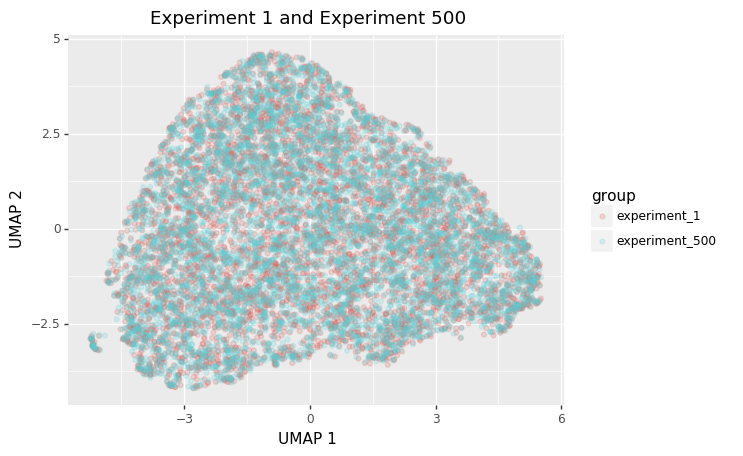

<ggplot: (8754120581366)>
Plotting UMAP of 10-PCA of 1 experiment vs 1000 experiments...
[0.04080816 0.02869818 0.00923079 0.00740885 0.00697174 0.00609036
 0.00543665 0.00444272 0.00402638 0.00390028]


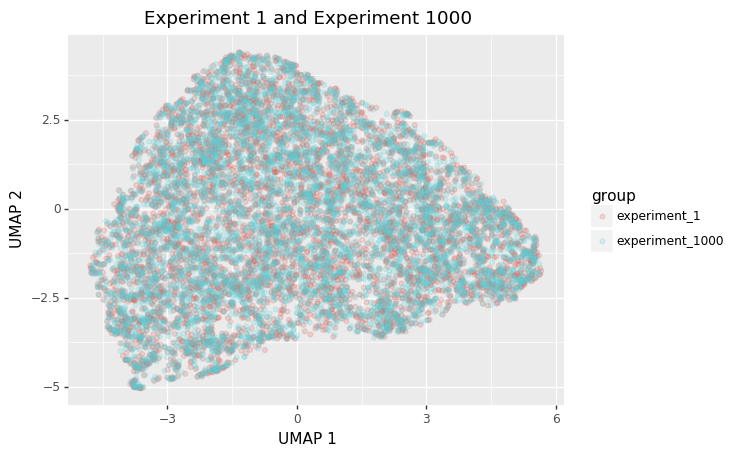

<ggplot: (8754108971293)>
Plotting UMAP of 10-PCA of 1 experiment vs 2000 experiments...
[0.04086553 0.02875921 0.00919919 0.00738871 0.00696102 0.00607235
 0.00545435 0.00441265 0.00398477 0.00386886]


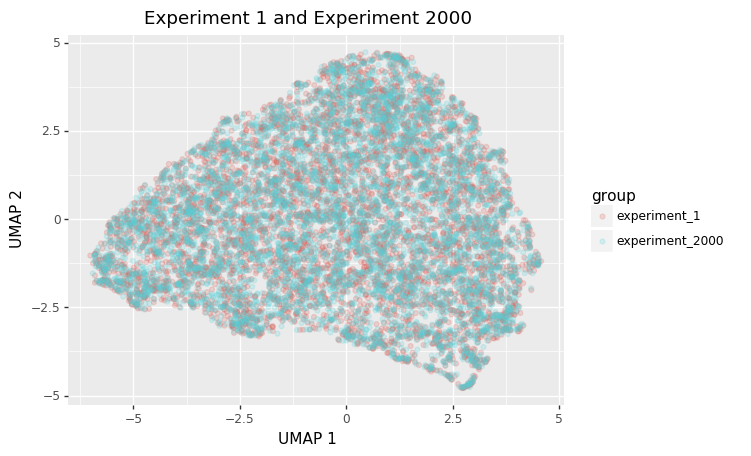

<ggplot: (-9223363282867702349)>
Plotting UMAP of 10-PCA of 1 experiment vs 3000 experiments...
[0.0407998  0.02868774 0.00916795 0.00736013 0.00692561 0.0060669
 0.0053914  0.00444419 0.00396096 0.0038609 ]


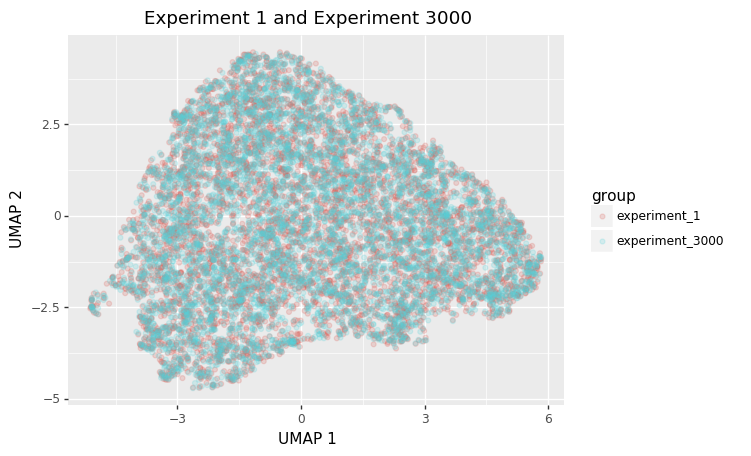

<ggplot: (8754108926419)>
Plotting UMAP of 10-PCA of 1 experiment vs 6000 experiments...
[0.04070829 0.02867088 0.00921433 0.00737665 0.00694506 0.00605603
 0.00542736 0.00442062 0.00394021 0.0038329 ]


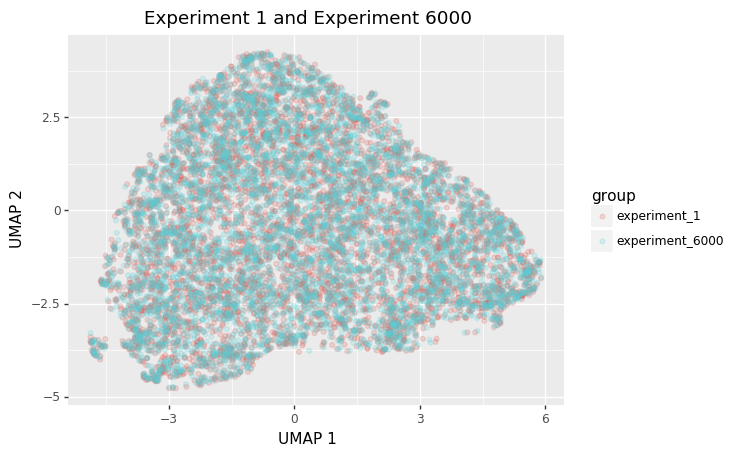

<ggplot: (-9223363282865634444)>
CPU times: user 5min 52s, sys: 1min 7s, total: 6min 59s
Wall time: 5min 3s


In [18]:
%%time

all_data_df = pd.DataFrame()

# Get batch 1 data
experiment_1_file = os.path.join(
    experiment_dir,
    "Experiment_1.txt.xz")

experiment_1 = pd.read_table(
    experiment_1_file,
    header=0,
    index_col=0,
    sep='\t')


for i in lst_num_experiments:
    print('Plotting UMAP of 10-PCA of 1 experiment vs {} experiments...'.format(i))
    
    # Simulated data with all samples in a single batch
    original_data_df =  experiment_1.copy()
    
    # Add grouping column for plotting
    original_data_df['group'] = 'experiment_1'
    
    # Get data with additional batch effects added
    experiment_other_file = os.path.join(
        experiment_dir,
        "Experiment_"+str(i)+".txt.xz")

    experiment_other = pd.read_table(
        experiment_other_file,
        header=0,
        index_col=0,
        sep='\t')
    
    # Simulated data with i batch effects
    experiment_data_df =  experiment_other
    
    # Add grouping column for plotting
    experiment_data_df['group'] = "experiment_{}".format(i)
    
    # Concatenate datasets together
    combined_data_df = pd.concat([original_data_df, experiment_data_df])
    
    # PCA projection
    pca = PCA(n_components=10)

    # Encode expression data into 2D PCA space
    combined_data_numeric_df = combined_data_df.drop(['group'], axis=1)
    combined_data_PCAencoded = pca.fit_transform(combined_data_numeric_df)


    combined_data_PCAencoded_df = pd.DataFrame(combined_data_PCAencoded,
                                               index=combined_data_df.index,
                                              )
    
    # Variance explained
    print(pca.explained_variance_ratio_)  
                                              
   
    # Encode 10-dim PCA compressed expression data into UMAP space
    combined_data_UMAPencoded = umap.UMAP(random_state=randomState).fit_transform(combined_data_PCAencoded_df)
    combined_data_UMAPencoded_df = pd.DataFrame(data=combined_data_UMAPencoded,
                                             index=combined_data_PCAencoded_df.index,
                                             columns=['UMAP1','UMAP2'])
    
    
    # Add back in batch labels (i.e. labels = "batch_"<how many batch effects were added>)
    combined_data_UMAPencoded_df['group'] = combined_data_df['group']
    
    # Add column that designates which batch effect comparision (i.e. comparison of 1 batch vs 5 batches
    # is represented by label = 5)
    combined_data_UMAPencoded_df['num_experiments'] = str(i)
    
    # Concatenate ALL comparisons
    all_data_df = pd.concat([all_data_df, combined_data_UMAPencoded_df])
    
    # Plot individual comparisons
    print(ggplot(combined_data_UMAPencoded_df, aes(x='UMAP1', y='UMAP2')) \
          + geom_point(aes(color='group'), alpha=0.2) \
          + labs(x = "UMAP 1", y = "UMAP 2", title = "Experiment 1 and Experiment {}".format(i))\
         )

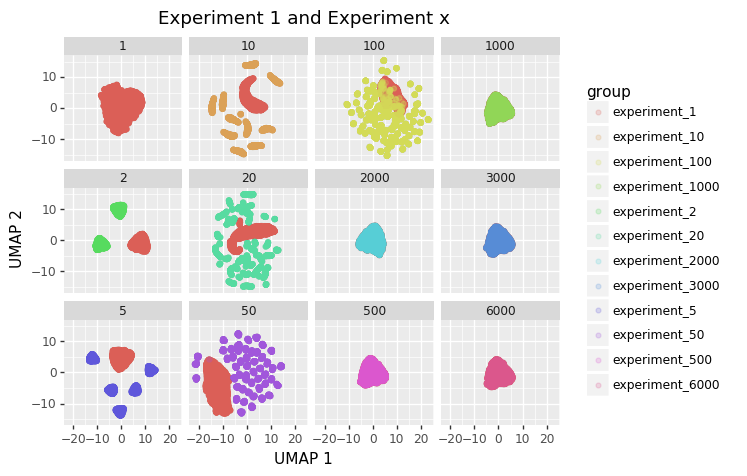

<ggplot: (8754180072028)>

In [19]:
# Plot all comparisons in one figure
ggplot(all_data_df, aes(x='UMAP1', y='UMAP2')) \
+ geom_point(aes(color='group'), alpha=0.2) \
+ facet_wrap('~num_experiments') \
+ labs(x = "UMAP 1", y = "UMAP 2", title = "Experiment 1 and Experiment x")\

**Note:** 

1. We are using PCA space to visualize the simulated data with different numbers of experiments added in order to detect the effect of the variance added by the different experiments.  UMAP is focused on trying to find the optimal low dimensional representation of the data that preserves the topological structures in the data in high dimensional space.  

2. In order to examine the structure that is captured in using 10 PCs (set by the user), we plotted the UMAP projection of the gene expression data compressed into the top 10 PCs.  We can see that there is some structure in the 10-PCA data.

## 3. Visualize variance corrected experiment data

Plotting PCA of 1 experiment vs 1 experiments...


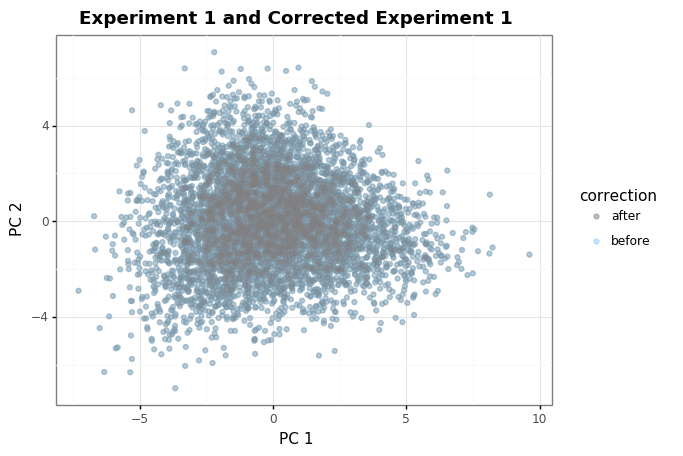

<ggplot: (8753984815841)>
Plotting PCA of 1 experiment vs 2 experiments...


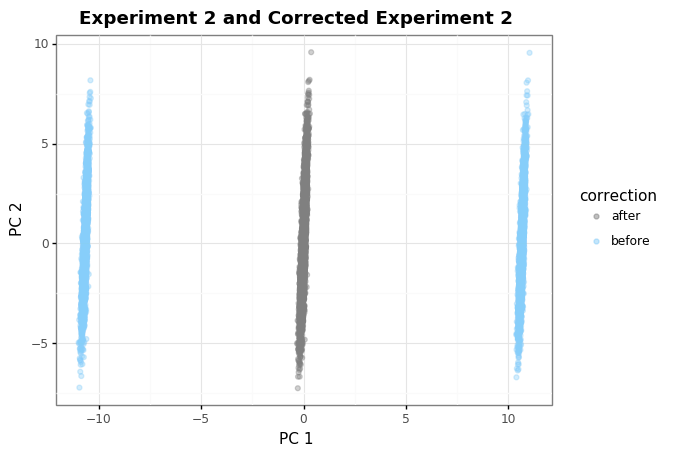

<ggplot: (-9223363282866267676)>
Plotting PCA of 1 experiment vs 5 experiments...


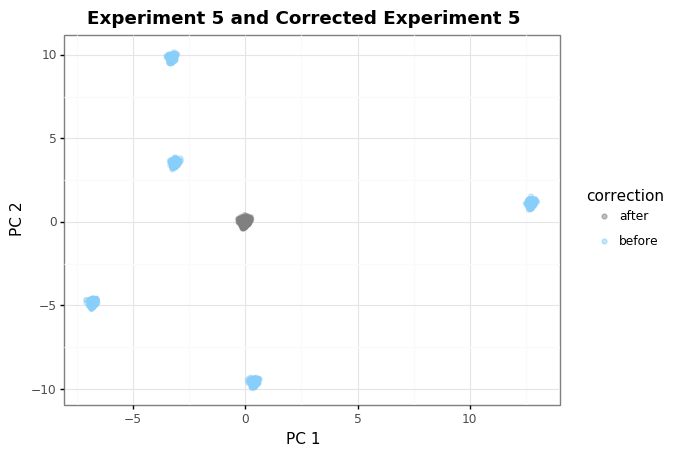

<ggplot: (8753984798668)>
Plotting PCA of 1 experiment vs 10 experiments...


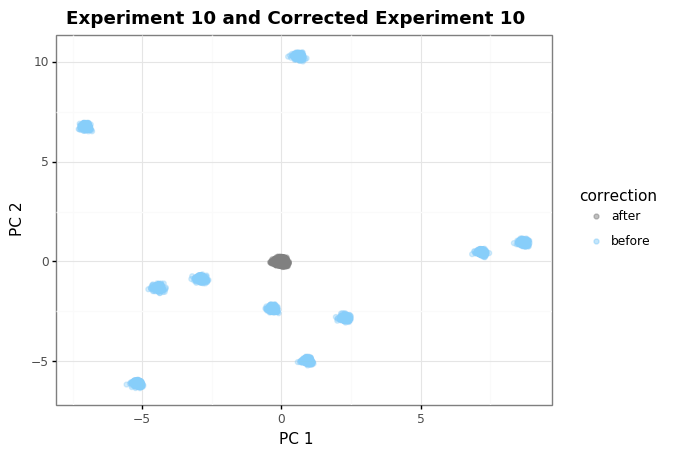

<ggplot: (-9223363282872395986)>
Plotting PCA of 1 experiment vs 20 experiments...


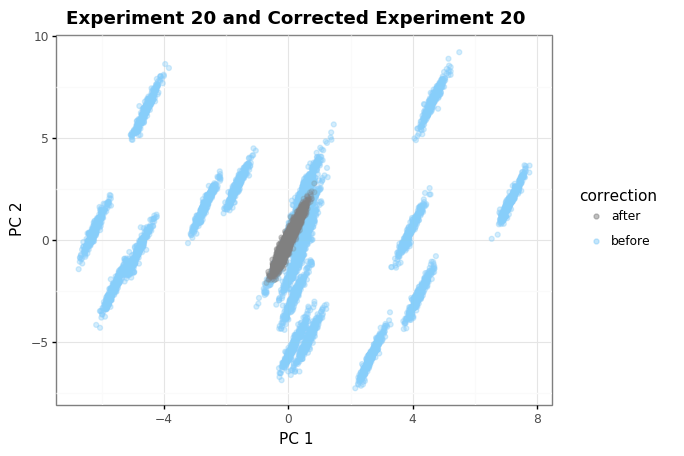

<ggplot: (-9223363282865886348)>
Plotting PCA of 1 experiment vs 50 experiments...


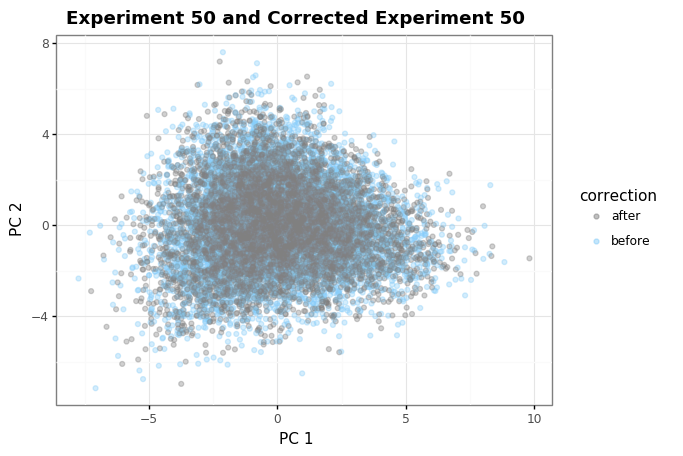

<ggplot: (8754109392539)>
Plotting PCA of 1 experiment vs 100 experiments...


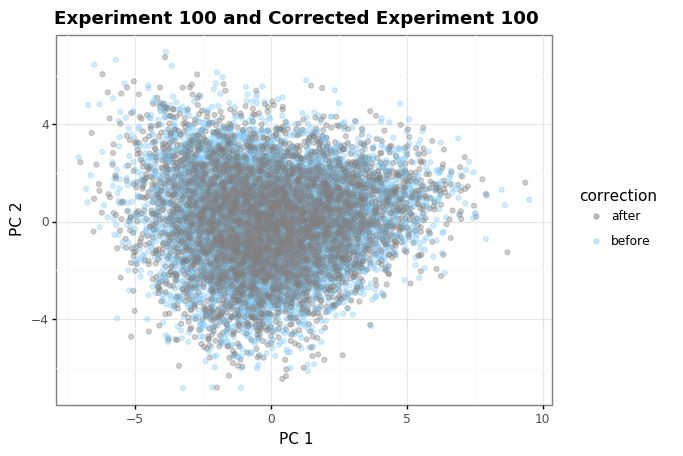

<ggplot: (-9223363282869238005)>
Plotting PCA of 1 experiment vs 500 experiments...


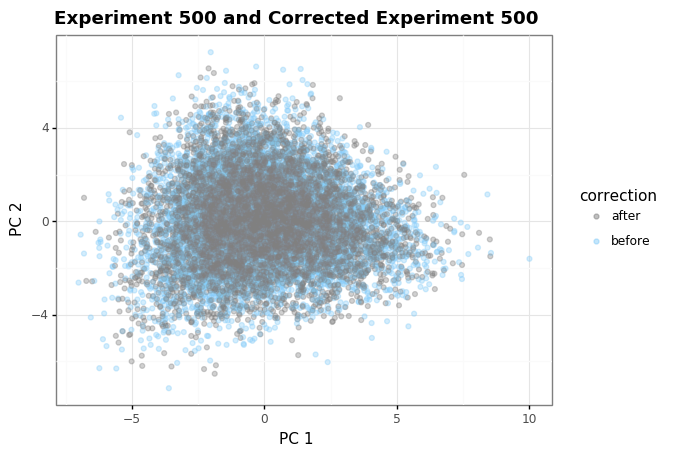

<ggplot: (-9223363282755038313)>
Plotting PCA of 1 experiment vs 1000 experiments...


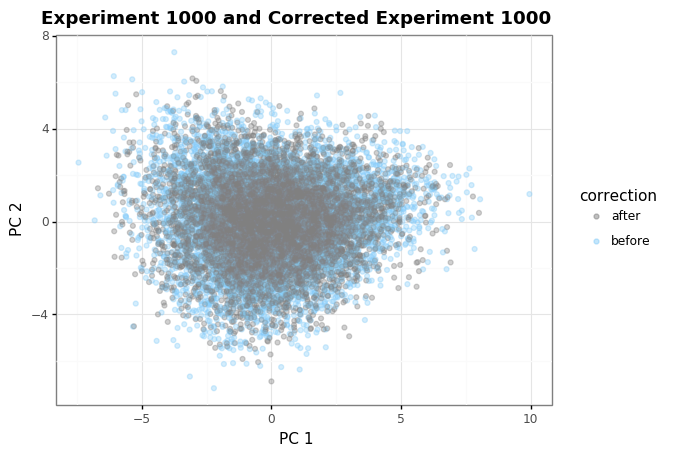

<ggplot: (8754091305213)>
Plotting PCA of 1 experiment vs 2000 experiments...


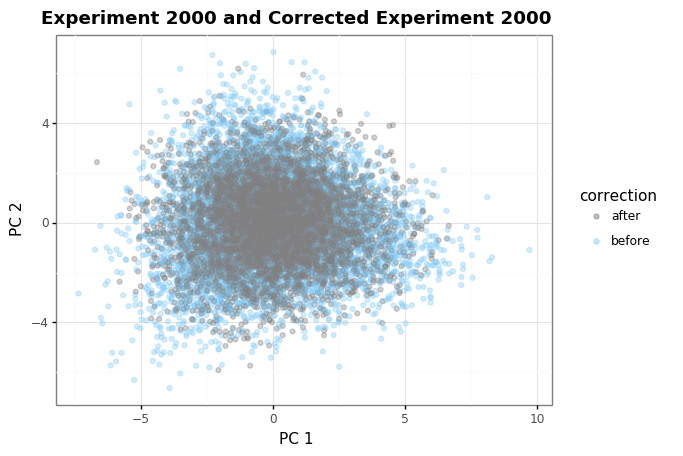

<ggplot: (-9223363282850532359)>
Plotting PCA of 1 experiment vs 3000 experiments...


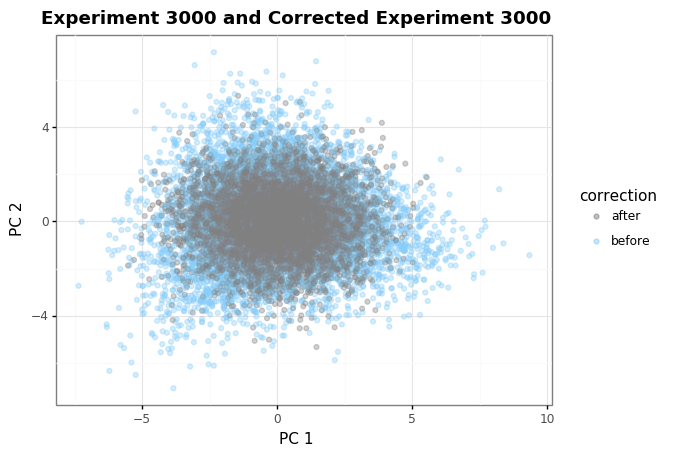

<ggplot: (-9223363282869432225)>
Plotting PCA of 1 experiment vs 6000 experiments...


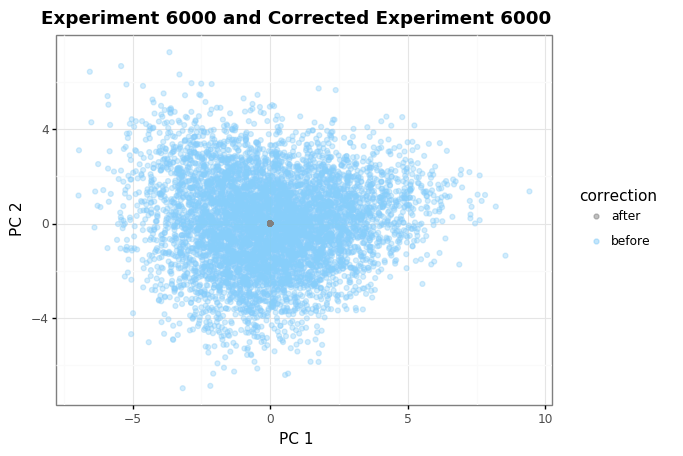

<ggplot: (-9223363282848839557)>
CPU times: user 4min 54s, sys: 54.2 s, total: 5min 48s
Wall time: 4min 16s


In [20]:
%%time

all_data_df = pd.DataFrame()

for i in lst_num_experiments:
    print('Plotting PCA of 1 experiment vs {} experiments...'.format(i))
    
     # Get data BEFORE correction
    experiment_before_file = os.path.join(
        experiment_dir,
        "Experiment_"+str(i)+".txt.xz")

    experiment_before = pd.read_table(
        experiment_before_file,
        header=0,
        index_col=0,
        sep='\t')
    
    # Match format of column names in before and after df
    experiment_before.columns = experiment_before.columns.astype(str)
    
    # Add grouping column for plotting
    experiment_before['correction'] = "before"
    
    # Get data with additional batch effects added
    experiment_after_file = os.path.join(
        experiment_dir,
        "Experiment_corrected_"+str(i)+".txt.xz")

    experiment_after = pd.read_table(
        experiment_after_file,
        header=0,
        index_col=0,
        sep='\t')
    
    # Transpose data to df: sample x gene
    experiment_after = experiment_after.T
    
    # Match format of column names in before and after df
    experiment_after.columns = experiment_after.columns.astype(str)
    
    # Add grouping column for plotting
    experiment_after['correction'] = "after"
        
    # Concatenate datasets together
    combined_data_df = pd.concat([experiment_before, experiment_after])
    
    # PCA projection
    pca = PCA(n_components=2)

    # Encode expression data into 2D PCA space    
    combined_data_numeric_df = combined_data_df.drop(['correction'], axis=1)    
    combined_data_PCAencoded = pca.fit_transform(combined_data_numeric_df)

    
    combined_data_PCAencoded_df = pd.DataFrame(combined_data_PCAencoded,
                                               index=combined_data_df.index,
                                               columns=['PC1', 'PC2']
                                              )
    
    # Add back in batch labels (i.e. labels = "batch_"<how many batch effects were added>)
    combined_data_PCAencoded_df['correction'] = combined_data_df['correction']
    
    # Add column that designates which batch effect comparision (i.e. comparison of 1 batch vs 5 batches
    # is represented by label = 5)
    combined_data_PCAencoded_df['num_experiments'] = str(i)
    
    # Concatenate ALL comparisons
    all_data_df = pd.concat([all_data_df, combined_data_PCAencoded_df])
    
    # Split dataframe in order to plot 'after' on top of 'before'
    df_layer_1 = combined_data_PCAencoded_df[combined_data_PCAencoded_df['correction'] == "before"]
    df_layer_2 = combined_data_PCAencoded_df[combined_data_PCAencoded_df['correction'] == "after"]

    
    # Plot individual comparisons
    print(ggplot(combined_data_PCAencoded_df, aes(x='PC1', y='PC2')) \
          + geom_point(aes(color='correction'), alpha=0.2) \
          + geom_point(df_layer_1, aes(color=['before']), alpha=0.2) \
          + geom_point(df_layer_2, aes(color=['after']), alpha=0.2) \
          + labs(x = "PC 1", y = "PC 2", title = "Experiment {} and Corrected Experiment {}".format(i, i)) \
          + theme_bw() \
          + theme(
                legend_title_align = "center",
                plot_background=element_rect(fill='white'),
                legend_key=element_rect(fill='white', colour='white'),
                plot_title=element_text(weight='bold')) \
          + scale_colour_manual(["grey", '#87CEFA'])
         )

In [21]:
# Convert 'comparison' into categories to preserve the ordering
num_experiments_cat = pd.Categorical(all_data_df['num_experiments'], categories=lst_num_experiments_str)

# Assign to a new column in the df
all_data_df = all_data_df.assign(num_experiments_cat = num_experiments_cat)

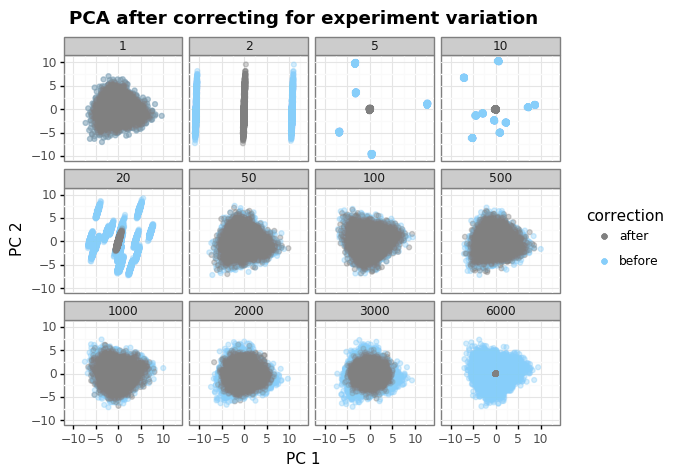

<ggplot: (-9223363282849338638)>


In [22]:
# Plot all comparisons in one figure

# Split dataframe in order to plot 'after' on top of 'before'
df_layer_1 = all_data_df[all_data_df['correction'] == "before"]
df_layer_2 = all_data_df[all_data_df['correction'] == "after"]

g_correct = ggplot(all_data_df, aes(x='PC1', y='PC2')) \
+ geom_point(aes(color='correction'), alpha=0.2) \
+ geom_point(df_layer_1, aes(color=['before']), alpha=0.2) \
+ geom_point(df_layer_2, aes(color=['after']), alpha=0.2) \
+ facet_wrap('~num_experiments_cat') \
+ labs(x = "PC 1", y = "PC 2", title = "PCA after correcting for experiment variation") \
+ theme_bw() \
+ theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    plot_title=element_text(weight='bold')) \
+ guides(colour=guide_legend(override_aes={'alpha': 1})) \
+ scale_colour_manual(["grey", '#87CEFA'])

print(g_correct)
ggsave(plot = g_correct, filename = pca_correct_file, dpi=300)

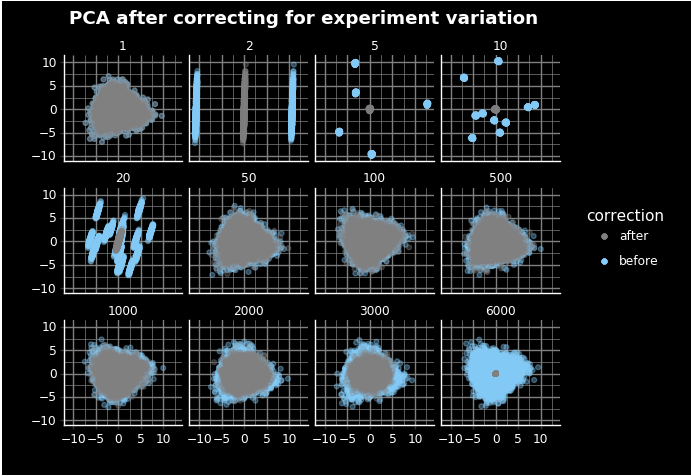

<ggplot: (-9223363282849460206)>


In [26]:
# Plot - black

# Split dataframe in order to plot 'after' on top of 'before'
df_layer_1 = all_data_df[all_data_df['correction'] == "before"]
df_layer_2 = all_data_df[all_data_df['correction'] == "after"]

g_correct = ggplot(all_data_df, aes(x='PC1', y='PC2')) \
+ geom_point(aes(color='correction'), alpha=0.2) \
+ geom_point(df_layer_1, aes(color=['before']), alpha=0.2) \
+ geom_point(df_layer_2, aes(color=['after']), alpha=0.2) \
+ facet_wrap('~num_experiments_cat') \
+ labs(x = "PC 1", y = "PC 2", title = "PCA after correcting for experiment variation") \
+ guides(colour=guide_legend(override_aes={'alpha': 1})) \
+ scale_colour_manual(["grey", '#87CEFA']) \
+ theme(
        plot_background=element_rect(fill='black'),
        legend_title_align = "center",
        legend_background=element_rect(fill='black', colour='black'),
        legend_key=element_rect(fill='black', colour='black'), 
        legend_title=element_text(colour="white"),
        legend_text=element_text(colour="white"),
        plot_title=element_text(weight='bold', colour="white"),
        panel_background=element_rect(fill="black"),
        axis_line=element_line(color="white"),
        axis_text=element_text(color="white"),
        panel_grid=element_line(colour="gray"),
        strip_text=element_text(colour="white"),
        strip_background=element_blank()
)

print(g_correct)
ggsave(plot = g_correct, filename = pca_correct_blk_file, dpi=300)

## Permuted dataset (Negative control)

As a negative control we will permute the values within a sample, across genes in order to disrupt the gene expression structure.

In [28]:
# Read in permuated data
shuffled_simulated_data = pd.read_table(
    permuted_simulated_data_file,
    header=0,
    index_col=0,
    sep='\t')

In [29]:
# Label samples with label = perumuted
shuffled_simulated_data['group'] = "permuted"

# Concatenate original simulated data and shuffled simulated data
input_vs_permuted_df = pd.concat([original_data_df, shuffled_simulated_data])


input_vs_permuted = input_vs_permuted_df.drop(['group'], axis=1)
shuffled_data_PCAencoded = pca.fit_transform(input_vs_permuted)


shuffled_data_PCAencoded_df = pd.DataFrame(shuffled_data_PCAencoded,
                                           index=input_vs_permuted_df.index,
                                           columns=['PC1', 'PC2']
                                          )

# Add back in batch labels (i.e. labels = "batch_"<how many batch effects were added>)
shuffled_data_PCAencoded_df['group'] = input_vs_permuted_df['group']

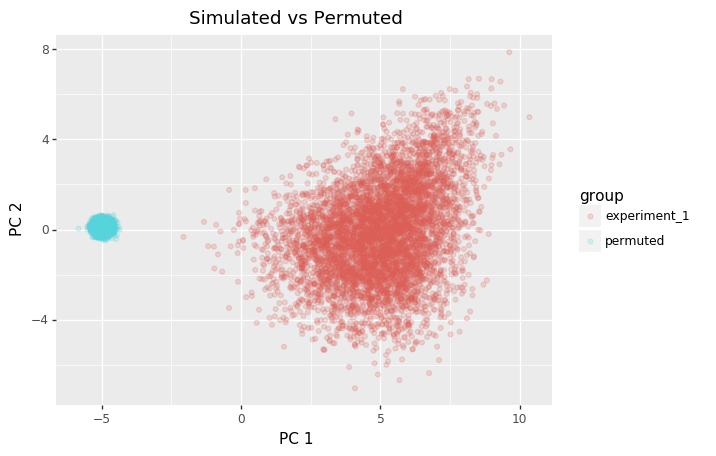

<ggplot: (8754109018674)>


In [30]:
# Plot permuted data
print(ggplot(shuffled_data_PCAencoded_df, aes(x='PC1', y='PC2')) \
      + geom_point(aes(color='group'), alpha=0.2) \
      + labs(x = "PC 1", y = "PC 2", title = "Simulated vs Permuted")\
     )